# Preprocessing

## JSON $\rightarrow$ Pandas
Turning metadatas json into useful and readable pandas dataframes

in order to make this script work you need to have the dataset in the working wolder such as:
```
>> fds-2022-final-project
    >> ...
    >> og_dataset
        >> slices.json
        >> splits
            >> train/
            >> dev/
            >> test/
```

In [1]:
import json
import os
import numpy as np
import pandas as pd

metadata_file = 'og_dataset/slices.geojson'
train_folder = 'og_dataset/splits/train/'
dev_folder   = 'og_dataset/splits/dev/'
test_folder  = 'og_dataset/splits/test/'

We first import the json file, and take only the information regarding all the patches, while adding to it the center of the longitude and latitude of the patch

In [2]:
with open(metadata_file) as f:
    d = json.load(f)
patches = d['features']
patches = [{
    **p['properties'], 
     'lng':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[0],
     'lat':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[1]
    } for p in patches]
patches[:2]

[{'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_000.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_000.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 77.38898468017578,
  'lng': 333795.9649122807,
  'lat': 3572176.06391926},
 {'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_001.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_001.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 133.6044158935547,
  'lng': 348977.8947368421,
  'lat': 3572176.06391926}]

Now we port the dataset into pandas and clean it, by:
- taking the number of the original img it came from
- taking the slice number
- using the 2 aforemwntioned features as index
- drop the name of the original file it came from
- combine (sum) the mean of layer 0 and 1 of the mask together
- drop the mean of layer 0 and 1 of the mask (since those are now combined in `mask_mean`)
- rename the `mask_mean_2` as `china`, since it's the percentage of china represented in the image

In [3]:
metadata = pd.DataFrame(patches)
files_columns = ['img_source','mask_source','img_slice','mask_slice']
metadata[files_columns] = metadata[files_columns].applymap(lambda x: x.split('/')[-1])
metadata['src'] = metadata.img_slice.map(lambda s: s.split('_')[1])
metadata['slice_num'] = metadata.img_slice.map(lambda s: s.split('_')[-1][:3])
metadata.set_index(['src', 'slice_num'], inplace=True)
metadata.drop(columns=['img_source', 'mask_source'], inplace=True)

metadata.head()

img_slice            mask_slice  mask_mean_0  \
src slice_num                                                           
0   000        slice_0_img_000.npy  slice_0_mask_000.npy          0.0   
    001        slice_0_img_001.npy  slice_0_mask_001.npy          0.0   
    002        slice_0_img_002.npy  slice_0_mask_002.npy          0.0   
    003        slice_0_img_003.npy  slice_0_mask_003.npy          0.0   
    004        slice_0_img_004.npy  slice_0_mask_004.npy          0.0   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
0   000                0.0          0.0   77.388985  333795.964912   
    001                0.0          0.0  133.604416  348977.894737   
    002                0.0          0.0   94.324028  364159.824561   
    003                0.0          0.0  189.766983  379341.754386   
    004                0.0          0.0  198.229507  394523.684211   

                        lat  
src slice_num                
0   000        3.572176e+06  
    001        3.572176e+06  
    002        3.572176e+06  
    003        3.572176e+06  
    004        3.572176e+06

Then we take the list of all the slice files for each folder

In [4]:
def list_files(folder):
    list_of_files = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            list_of_files.append(file)
    return list_of_files

train_splits = list_files(train_folder)
dev_splits = list_files(dev_folder)
test_splits = list_files(test_folder)

train_splits[:3]

['slice_12_mask_125.npy', 'slice_20_mask_043.npy', 'slice_10_img_186.npy']

And finally we partition the metadata in 3 different datasets

In [5]:
def partition_metadata(metadata, splits, folder = ''):
    # takes only the rows corresponding to those in the splits
    res = metadata[metadata.img_slice.isin( splits )].copy()
    # then adds the 
    res.img_slice = folder + res.img_slice
    res.mask_slice = folder + res.mask_slice
    return res

test_data = partition_metadata(metadata, test_splits, folder=test_folder)
dev_data = partition_metadata(metadata, dev_splits, folder=dev_folder)
train_data = partition_metadata(metadata, train_splits, folder=train_folder)

train_data.head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice  mask_mean_0  \
src slice_num                                                              
1   150        og_dataset/splits/train/slice_1_mask_150.npy     0.185390   
    165        og_dataset/splits/train/slice_1_mask_165.npy     0.108147   
    168        og_dataset/splits/train/slice_1_mask_168.npy     0.161293   
    185        og_dataset/splits/train/slice_1_mask_185.npy     0.191673   
    186        og_dataset/splits/train/slice_1_mask_186.npy     0.137325   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
1   150           0.184795     0.000595  382.686157  445035.967865   
    165           0.108147     0.000000  370.955048  445035.967865   
    168           0.161293     0.000000  437.918457  490581.775057   
    185           0.191673     0.000000  448.878815  520945.646519   
    186           0.137302     0.000023  349.251465  536127.582249   

                        lat  
src slice_num                
1   150        4.200787e+06  
    165        4.215970e+06  
    168        4.215970e+06  
    185        4.231152e+06  
    186        4.231152e+06

In [6]:
test_data.to_csv('dataset/test_data.csv')
train_data.to_csv('dataset/train_data.csv')
dev_data.to_csv('dataset/dev_data.csv')

Now, to load a dataset:

In [7]:
pd.read_csv('dataset/train_data.csv', index_col=['src','slice_num']).head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice  mask_mean_0  \
src slice_num                                                              
1   150        og_dataset/splits/train/slice_1_mask_150.npy     0.185390   
    165        og_dataset/splits/train/slice_1_mask_165.npy     0.108147   
    168        og_dataset/splits/train/slice_1_mask_168.npy     0.161293   
    185        og_dataset/splits/train/slice_1_mask_185.npy     0.191673   
    186        og_dataset/splits/train/slice_1_mask_186.npy     0.137325   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
1   150           0.184795     0.000595  382.686157  445035.967865   
    165           0.108147     0.000000  370.955048  445035.967865   
    168           0.161293     0.000000  437.918457  490581.775057   
    185           0.191673     0.000000  448.878815  520945.646519   
    186           0.137302     0.000023  349.251465  536127.582249   

                        lat  
src slice_num                
1   150        4.200787e+06  
    165        4.215970e+06  
    168        4.215970e+06  
    185        4.231152e+06  
    186        4.231152e+06

## Extract infos from metadata
We now want to get some informations out of the JSONs we just worked with

### China percentage

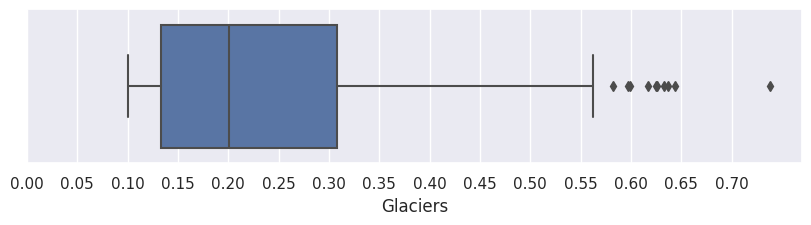

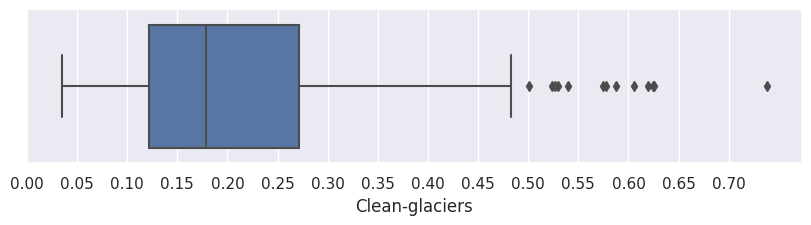

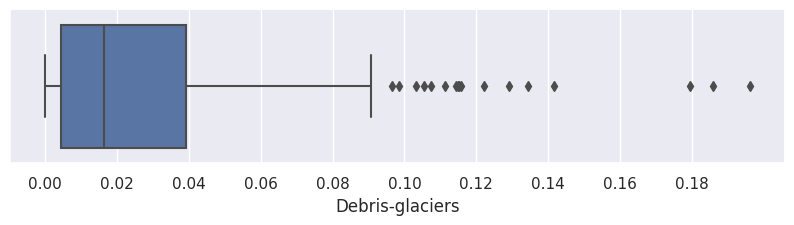

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set(rc={"figure.figsize":(10, 2)})

sns.boxplot(data=train_data, x='mask_mean_0')
plt.xticks(np.arange(0,train_data.mask_mean_0.max(), .05))
plt.xlabel('Glaciers')
plt.show()

sns.boxplot(data=train_data, x='mask_mean_1')
plt.xticks(np.arange(0,train_data.mask_mean_1.max(), .05))
plt.xlabel('Clean-glaciers')
plt.show()

sns.boxplot(data=train_data, x='mask_mean_2')
plt.xticks(np.arange(0,train_data.mask_mean_2.max(), .02))
plt.xlabel('Debris-glaciers')
plt.show()

We can see that almost all of the values are in the range $(0, 0.04)$ and that only few outliers are above $0.1$.

## Create new Masks

We now want to read all the masks, which are $512 \times 512 \times 3$ `np.array` and we want to sum just the first 2 layers between themselves, as the layers of the array represent:
1. Clean-ice Glacier
2. Debris covered glacier
3. Is in china

We first load each matrix, but it appears some of the files are corrupted:

In [9]:
def load(file):
    try:
        return np.load(file)
    except:
        return pd.NA
    
test_data['np_mask'] = test_data.mask_slice.apply(lambda x: load(x))
train_data['np_mask'] = train_data.mask_slice.apply(lambda x: load(x))
dev_data['np_mask'] = dev_data.mask_slice.apply(lambda x: load(x))

Then we get the percentage of HKH in the patch, this differs from china for some reason

In [10]:
test_data['debris_mean'] = test_data.np_mask.map(lambda m: m[:,:,1].mean(), na_action='ignore')
dev_data['debris_mean'] = dev_data.np_mask.map(lambda m: m[:,:,1].mean(), na_action='ignore')
train_data['debris_mean'] = train_data.np_mask.map(lambda m: m[:,:,1].mean(), na_action='ignore')

Then we combine together the first 2 layers of the masks:

In [11]:
test_data['clean_mean'] = test_data.np_mask.map(lambda m: m[:,:,0].mean(), na_action='ignore')
dev_data['clean_mean'] = dev_data.np_mask.map(lambda m: m[:,:,0].mean(), na_action='ignore')
train_data['clean_mean'] = train_data.np_mask.map(lambda m: m[:,:,0].mean(), na_action='ignore')

Finally we compute the mean of each of the masks:

In [12]:
test_data['glacier_perc'] = test_data.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')
train_data['glacier_perc'] = train_data.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')
dev_data['glacier_perc'] = dev_data.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')

train_data.head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice  mask_mean_0  \
src slice_num                                                              
1   150        og_dataset/splits/train/slice_1_mask_150.npy     0.185390   
    165        og_dataset/splits/train/slice_1_mask_165.npy     0.108147   
    168        og_dataset/splits/train/slice_1_mask_168.npy     0.161293   
    185        og_dataset/splits/train/slice_1_mask_185.npy     0.191673   
    186        og_dataset/splits/train/slice_1_mask_186.npy     0.137325   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
1   150           0.184795     0.000595  382.686157  445035.967865   
    165           0.108147     0.000000  370.955048  445035.967865   
    168           0.161293     0.000000  437.918457  490581.775057   
    185           0.191673     0.000000  448.878815  520945.646519   
    186           0.137302     0.000023  349.251465  536127.582249   

                        lat  \
src slice_num                 
1   150        4.200787e+06   
    165        4.215970e+06   
    168        4.215970e+06   
    185        4.231152e+06   
    186        4.231152e+06   

                                                         np_mask debris_mean  \
src slice_num                                                                  
1   150        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...    0.000595   
    165        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...         0.0   
    168        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...         0.0   
    185        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...         0.0   
    186        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...    0.000023   

              clean_mean glacier_perc  
src slice_num                          
1   150         0.184795      0.18539  
    165         0.108147     0.108147  
    168         0.161293     0.161293  
    185         0.191673     0.191673  
    186         0.137302     0.137325

We notice that strangely the debris_mean and the clean_mean _almost_ add up to 1

### Glaciers percentage
Finally we can see the distribution of percentages of glaciers

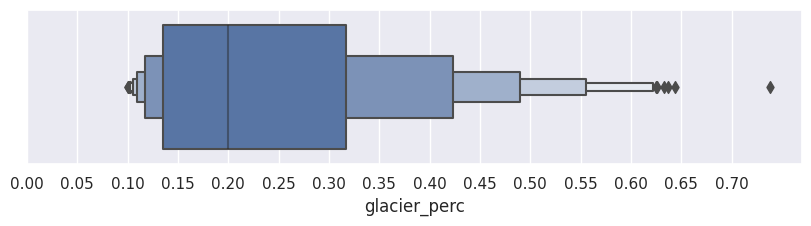

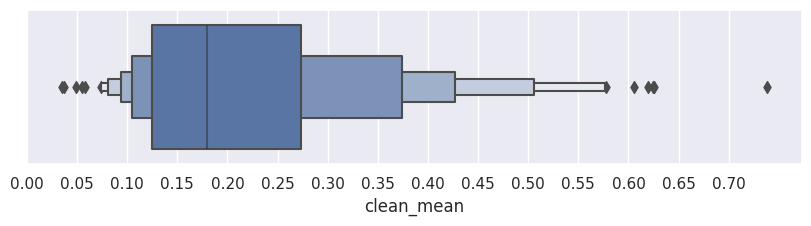

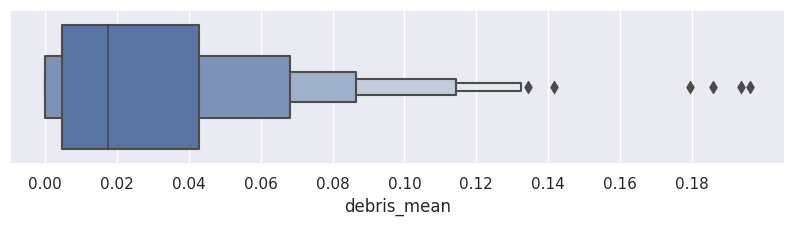

In [13]:
sns.boxenplot(data=train_data.dropna(), x='glacier_perc' )
plt.xticks(np.arange(0,train_data.glacier_perc.max(),0.05))
plt.show()

sns.boxenplot(data=train_data.dropna(), x='clean_mean' )
plt.xticks(np.arange(0,train_data.clean_mean.max(),0.05))
plt.show()

sns.boxenplot(data=train_data.dropna(), x='debris_mean' )
plt.xticks(np.arange(0,train_data.debris_mean.max(),0.02))
plt.show()

Aside from the data being a little strange since they are sometimes bigger than 1, I would say that the optimal choice for the **threshold** should be $0.2$.

In [14]:
## Save the new np masks, unnecesary
# dev_data\
#     .reset_index()\
#     .apply(lambda r: 
#             np.save(f'dataset/masks/dev/slice_{r.src}_mask_{r.slice_num}.npy', r.np_mask),
#            axis=1)
# ;

### Creating Label for images based on our threshold value of 0.2 and Masks of the image.

> Those images with pixels less than 20% are identified as non-glacier image and more than 20% as glacier image

In [15]:
THRESHOLD = 0.2
train_data['label'] = train_data.glacier_perc.map(lambda x: 1 if x > THRESHOLD else 0, na_action='ignore')
test_data['label']  = test_data.glacier_perc.map(lambda x: 1 if x > THRESHOLD else 0, na_action='ignore')
dev_data['label']   = dev_data.glacier_perc.map(lambda x: 1 if x > THRESHOLD else 0, na_action='ignore')
train_data.head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice  mask_mean_0  \
src slice_num                                                              
1   150        og_dataset/splits/train/slice_1_mask_150.npy     0.185390   
    165        og_dataset/splits/train/slice_1_mask_165.npy     0.108147   
    168        og_dataset/splits/train/slice_1_mask_168.npy     0.161293   
    185        og_dataset/splits/train/slice_1_mask_185.npy     0.191673   
    186        og_dataset/splits/train/slice_1_mask_186.npy     0.137325   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
1   150           0.184795     0.000595  382.686157  445035.967865   
    165           0.108147     0.000000  370.955048  445035.967865   
    168           0.161293     0.000000  437.918457  490581.775057   
    185           0.191673     0.000000  448.878815  520945.646519   
    186           0.137302     0.000023  349.251465  536127.582249   

                        lat  \
src slice_num                 
1   150        4.200787e+06   
    165        4.215970e+06   
    168        4.215970e+06   
    185        4.231152e+06   
    186        4.231152e+06   

                                                         np_mask debris_mean  \
src slice_num                                                                  
1   150        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...    0.000595   
    165        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...         0.0   
    168        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...         0.0   
    185        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...         0.0   
    186        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...    0.000023   

              clean_mean glacier_perc label  
src slice_num                                
1   150         0.184795      0.18539     0  
    165         0.108147     0.108147     0  
    168         0.161293     0.161293     0  
    185         0.191673     0.191673     0  
    186         0.137302     0.137325     0

### Checking Counts for different classes for each set

In [16]:
train_data.label.value_counts()

0    173
1    173
Name: label, dtype: int64

#### We see that choosing threshold of  *20%* of number of pixels identified as snow gives us a balanced training dataset

In [17]:
test_data.label.value_counts()

1    59
0    40
Name: label, dtype: int64

In [18]:
dev_data.label.value_counts()

1    34
0    21
Name: label, dtype: int64

#### Validation set also seems to be more or less balanced (60%,40% split between the two class)

In [19]:
test_data.to_csv('dataset/test_data.csv')
train_data.to_csv('dataset/train_data.csv')
dev_data.to_csv('dataset/dev_data.csv')

## Distributions of features and binning
We now want to get a feel of what's the distribution of values of the 15 channels:
1. LE7 B1 (blue)
2. LE7 B2 (green)
3. LE7 B3 (red)
4. LE7 B4 (near infrared)
5. LE7 B5 (shortwave infrared 1)
6. LE7 B6_VCID_1 (low-gain thermal infrared)
7. LE7 B6_VCID_2 (high-gain thermal infrared)
8. LE7 B7 (shortwave infrared 2)
9. LE7 B8 (panchromatic)
10. LE7 BQA (quality bitmask)
11. NDVI (vegetation index)
12. NDSI (snow index)
13. NDWI (water index)
14. SRTM 90 elevation
15. SRTM 90 slope

In [22]:
np.histogram(np.load(train_folder + 'slice_1_img_150.npy')[:,:,2], density=True)
# np.load(train_folder + 'slice_1_img_150.npy')
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
dev_data['features'] = dev_data.img_slice.apply(lambda x: load(x))

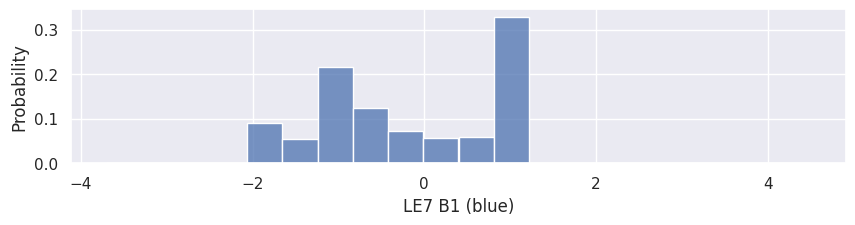

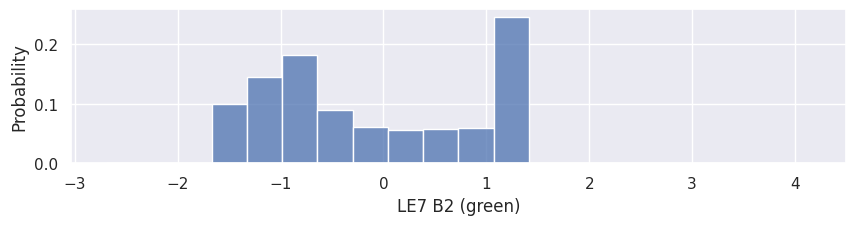

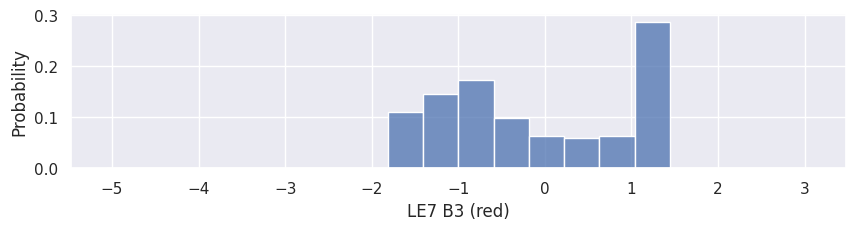

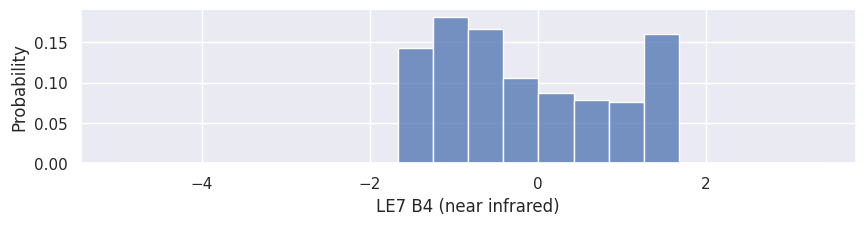

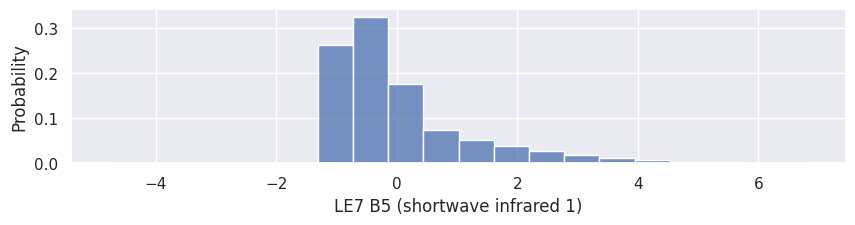

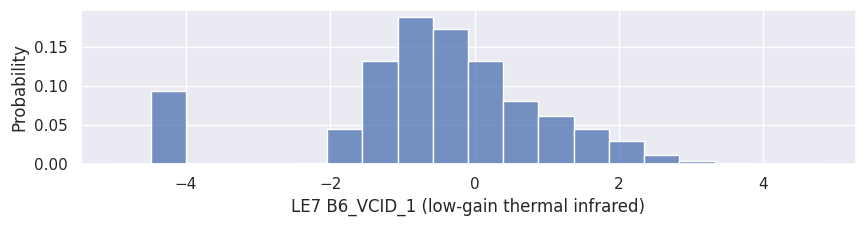

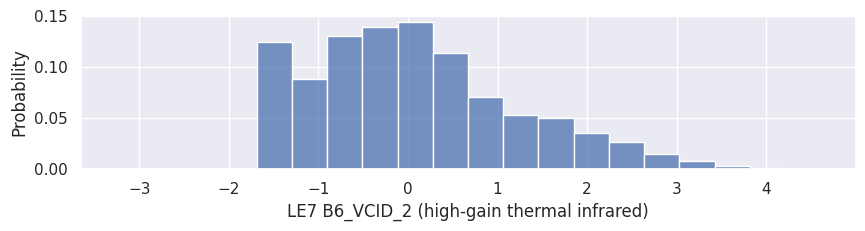

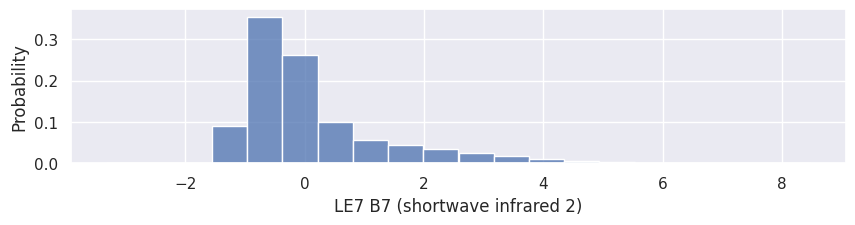

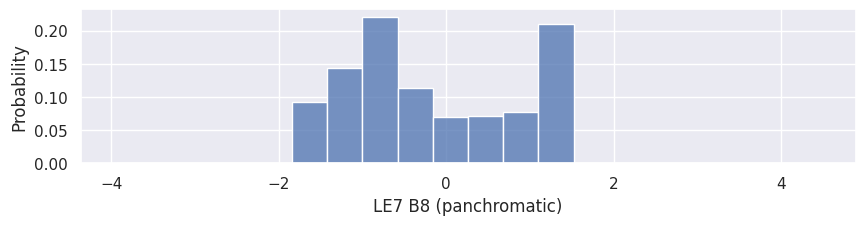

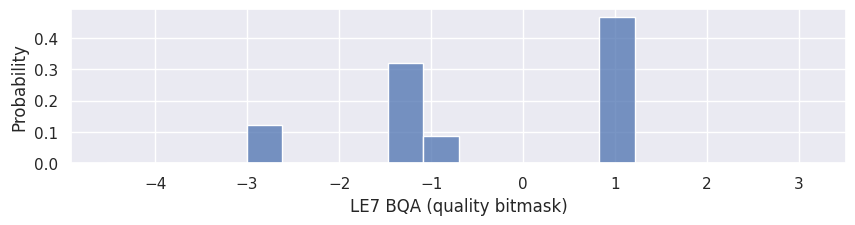

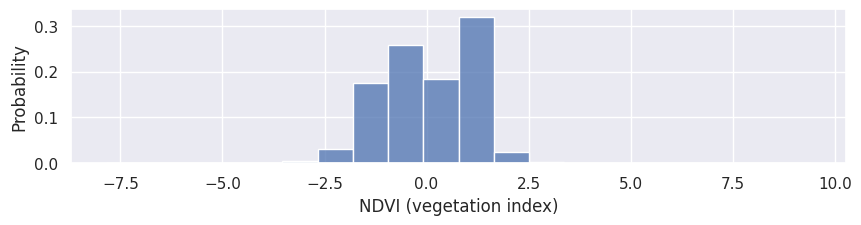

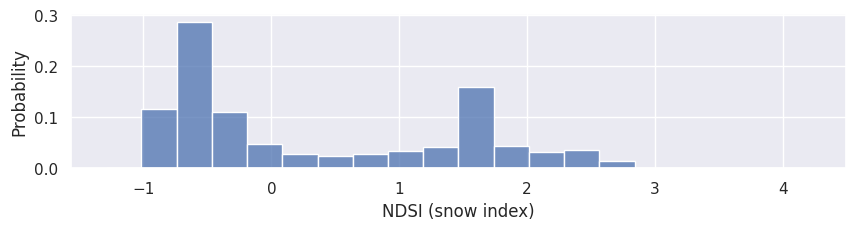

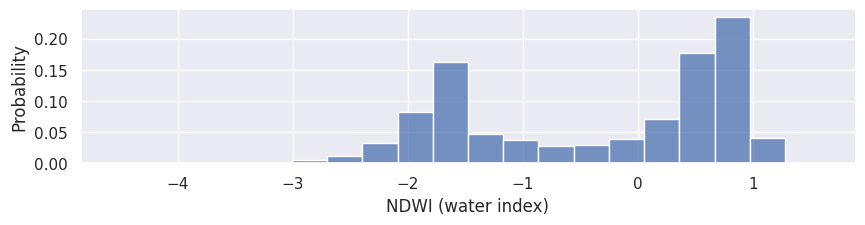

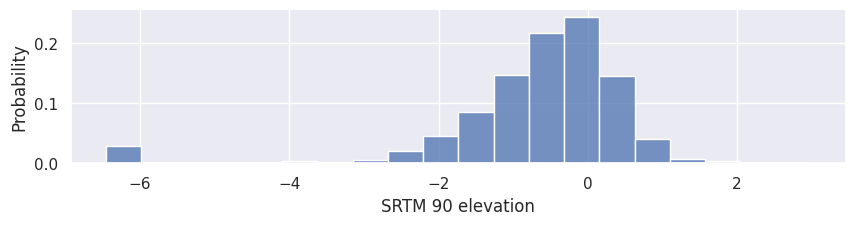

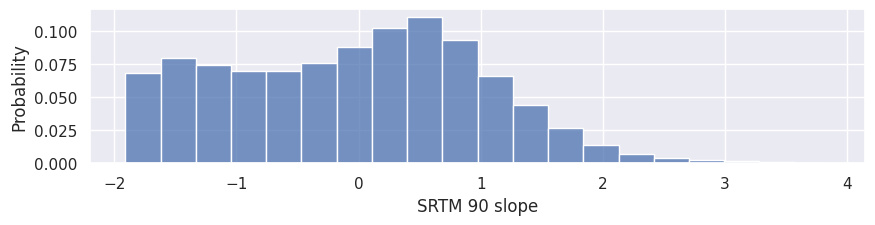

In [32]:
descr = pd.DataFrame() 

feature_names = ['LE7 B1 (blue)', 'LE7 B2 (green)', 'LE7 B3 (red)', 'LE7 B4 (near infrared)', 'LE7 B5 (shortwave infrared 1)', 'LE7 B6_VCID_1 (low-gain thermal infrared)', 'LE7 B6_VCID_2 (high-gain thermal infrared)', 'LE7 B7 (shortwave infrared 2)', 'LE7 B8 (panchromatic)', 'LE7 BQA (quality bitmask)', 'NDVI (vegetation index)', 'NDSI (snow index)', 'NDWI (water index)', 'SRTM 90 elevation', 'SRTM 90 slope']
for i,name in enumerate(feature_names):
    d_i = dev_data.features.apply(lambda m: m[:,:,i].flatten()).agg(np.concatenate)
    p01 = np.percentile(d_i, 1e-5)
    p99 = np.percentile(d_i, 1 - 1e-5)
    # print(p01, p99)
    d_i = d_i[(d_i>=-10) & (d_i<=10)]
    
    descr = pd.concat([
        descr, 
        pd.Series(d_i, name=name).describe(percentiles=[.1,.25,.5,.75,.9])
    ], axis=1)
    
    sns.histplot(x=d_i, stat='probability', bins=20)
    plt.xlabel(name)
    plt.show()

It appears that there are some extreme outliers:
May be caused by the corrupted files in my harddisk?

In [52]:
BIN_SIZE = 0.5

descr = descr.transpose()
descr['layer'] = range(0,15)
descr['bins'] = descr.apply(lambda x: np.arange(x['min'], x['max'], BIN_SIZE), axis=1)
descr

,count,mean,std,min,10%,25%,50%,75%,90%,max,layer,bins
LE7 B1 (blue),14417833.0,-0.122646,1.063114,-3.703597,-1.408958,-1.036306,-0.337583,1.199606,1.199606,4.501071,0,"[-3.703596830368042, -3.203596830368042, -2.70..."
LE7 B2 (green),14417826.0,-0.115830,1.008735,-2.695384,-1.331465,-0.975435,-0.385762,1.049482,1.260875,4.151711,1,"[-2.6953837871551514, -2.1953837871551514, -1...."
LE7 B3 (red),14417828.0,-0.105703,1.049174,-5.067105,-1.449632,-1.018387,-0.326127,1.217273,1.217273,3.071538,2,"[-5.067105293273926, -4.567105293273926, -4.06..."
LE7 B4 (near infrared),14417834.0,-0.137736,1.042717,-5.027516,-1.373231,-1.009058,-0.381174,0.761575,1.602939,3.359392,3,"[-5.027515888214111, -4.527515888214111, -4.02..."
LE7 B5 (shortwave infrared 1),14417834.0,0.035273,1.199618,-4.818408,-1.020440,-0.753380,-0.308281,0.374204,1.768847,6.869581,4,"[-4.818408012390137, -4.318408012390137, -3.81..."
LE7 B6_VCID_1 (low-gain thermal infrared),14417827.0,-0.524326,1.507835,-4.969496,-1.854737,-1.148095,-0.441453,0.312299,1.301598,4.787698,5,"[-4.969496250152588, -4.469496250152588, -3.96..."
LE7 B6_VCID_2 (high-gain thermal infrared),14417829.0,0.074276,1.137364,-3.261882,-1.444486,-0.793731,-0.088746,0.697583,1.755061,4.602115,6,"[-3.2618818283081055, -2.7618818283081055, -2...."
LE7 B7 (shortwave infrared 2),14417826.0,0.099517,1.183343,-3.328865,-0.904364,-0.676236,-0.285161,0.399221,1.865754,8.482666,7,"[-3.328864574432373, -2.828864574432373, -2.32..."
LE7 B8 (panchromatic),14417828.0,-0.128004,1.023537,-3.947545,-1.330488,-0.971371,-0.461655,0.893723,1.449776,4.470350,8,"[-3.947545051574707, -3.447545051574707, -2.94..."
LE7 BQA (quality bitmask),14417827.0,-0.422464,1.311692,-4.531066,-2.778904,-1.339518,-0.791180,0.862401,0.870968,3.126436,9,"[-4.531065940856934, -4.031065940856934, -3.53..."


In [79]:
histos = pd.DataFrame()
for i, name in enumerate(feature_names):
    histos[name] = dev_data.features.apply(
        lambda m, bins: np.histogram(m[:,:,i], bins=bins, density=True)[0], 
        args=(descr.bins.to_list()[i],))
    
histos.head()

LE7 B1 (blue)  \
src slice_num                                                      
2   047        [0.00012207683210620684, 3.814901003318964e-05...   
    173        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0097808837890625, ...   
    207        [0.0, 0.0, 0.0, 1.0128407178590917, 3.05277096...   
3   056        [0.0, 0.0, 0.0, 0.0, 0.02642059326171875, 0.64...   
4   106        [0.0, 0.0, 0.0, 0.06133270263671875, 0.0121612...   

                                                  LE7 B2 (green)  \
src slice_num                                                      
2   047        [6.866455078125e-05, 0.00125885009765625, 0.31...   
    173        [0.0, 0.0, 0.0, 0.01676177978515625, 0.1296997...   
    207        [0.0, 0.0, 0.9094142339248235, 0.0054951345163...   
3   056        [0.0, 0.0, 0.02349090576171875, 0.587875366210...   
4   106        [0.0, 0.0, 0.13848876953125, 0.189605712890625...   

                                                    LE7 B3 (red)  \
src slice_num                                                      
2   047        [0.0, 0.0, 0.0, 0.0, 3.814697265625e-05, 0.000...   
    173        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00340270...   
    207        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8073435806633...   
3   056        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18066406...   
4   106        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2179718017578...   

                                          LE7 B4 (near infrared)  \
src slice_num                                                      
2   047        [7.629627368999298e-06, 0.0, 0.0, 0.0, 0.0, 0....   
    173        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00800323...   
    207        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7039128742492...   
3   056        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.74586486...   
4   106        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3171920776367...   

                                   LE7 B5 (shortwave infrared 1)  \
src slice_num                                                      
2   047        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.57763671875e-...   
    173        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15577697...   
    207        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49171557...   
3   056        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07736968...   
4   106        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.60787200...   

                       LE7 B6_VCID_1 (low-gain thermal infrared)  \
src slice_num                                                      
2   047        [0.0, 0.8673171997070312, 0.0, 0.0, 0.0, 1.525...   
    173        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0352249145507...   
    207        [0.0, 0.2712983350569164, 2.289630644416545e-0...   
3   056        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02975463...   
4   106        [0.0, 0.7511749267578125, 0.0, 0.0, 0.0, 0.0, ...   

                      LE7 B6_VCID_2 (high-gain thermal infrared)  \
src slice_num                                                      
2   047        [0.0, 0.0, 0.0, 0.8910293579101562, 0.24763488...   
    173        [0.0, 0.0, 0.0, 0.0033721923828125, 0.24330902...   
    207        [0.0, 0.0, 0.0, 0.2806913105364182, 0.26847240...   
3   056        [0.0, 0.0, 0.0, 0.0, 0.0081939697265625, 0.147...   
4   106        [0.0, 0.0, 0.0, 0.7511749267578125, 0.0, 0.001...   

                                   LE7 B7 (shortwave infrared 2)  \
src slice_num                                                      
2   047        [0.00019073486328125, 0.0, 0.0, 0.0, 0.6679763...   
    173        [0.0, 0.0, 0.0, 0.0, 0.09748077392578125, 0.62...   
    207        [0.0, 0.0, 0.0, 0.0, 0.5566571265025758, 0.209...   
3   056        [0.0, 0.0, 0.0, 0.0, 0.00621795654296875, 0.58...   
4   106        [0.0, 0.0, 0.0, 0.0, 0.5051193237304688, 0.068...   

                                           LE7 B8 (panchromatic)  \
src slice_num                                                      
2   047        [0.0, 7.629598263503435e-05, 0.000198369554851...   
    173        [0.0, 0.0, 0.0, 